In [23]:
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series

In [24]:
apple_close_price = get_apple_close_price()

In [25]:
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [26]:
train, test = train_test_split(apple_close_price, 
                               test_size=0.05, 
                               shuffle=False)

In [27]:
# boxcox_series, lmbda = boxcox(train.values)

In [28]:
# transformed_train = boxcox_series
# transformed_test = boxcox(test, lmbda=lmbda)

transformed_train = train.values
transformed_test = test.values

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
scaler = MinMaxScaler()

In [31]:
# scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
# scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [32]:
# Core layers
from keras.layers \
    import Activation, Dropout, Flatten, Dense, Input, LeakyReLU, Reshape

# Recurrent layers
from keras.layers import LSTM

# Convolutional layers
from keras.layers import Conv1D, MaxPooling1D

# Normalization layers
from keras.layers import BatchNormalization

# Merge layers
from keras.layers import concatenate

# Layer wrappers
from keras.layers import Bidirectional, TimeDistributed

# Keras models
from keras.models import Model, Sequential

# Keras optimizers
from keras.optimizers import Adam, RMSprop

import keras.backend as K

import warnings
warnings.simplefilter('ignore')

In [46]:
look_back = 3
n_features = 1

In [47]:
X_train, y_train = split_sequence(scaled_train, look_back)
X_test, y_test = split_sequence(scaled_test, look_back)

In [48]:
def build_generator_net(look_back, n_features):
    net = Sequential()

    net.add(LSTM(50, input_shape=(look_back, n_features)))
    net.add(LeakyReLU(alpha=0.2))
    net.add(Dense(n_features))

    print('Generator summary:')
    net.summary()
    
    return net

In [49]:
def build_discriminator_net(look_back, n_features):
    net = Sequential()

    net.add(Conv1D(64, 
                   kernel_size=2, 
                   padding='same', 
                   input_shape=(look_back + 1, n_features))) # +1 => +target
    net.add(LeakyReLU(alpha=0.2))
    net.add(Flatten())
    net.add(Dense(1, activation='sigmoid'))

    print('Discriminator summary:')
    net.summary()
    
    return net

In [50]:
def build_discriminator_model(look_back, n_features, optimizer=Adam()):
    dis_net = build_discriminator_net(look_back, n_features)
    
    net = Sequential()
    net.add(dis_net)
    
    seq = Input((look_back + 1, n_features))
    valid = net(seq)
    
    model = Model(seq, valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return model, dis_net

In [51]:
def build_adversarial_model(look_back, n_features, dm_optimizer=Adam(), am_optimizer=Adam()):
    
    dis_model, dis_net = build_discriminator_model(look_back, n_features, optimizer=dm_optimizer)
    
    gen_net = build_generator_net(look_back, n_features)
    
    net = Sequential()
    net.add(gen_net)
    
    gen_input = Input((look_back, n_features))
    gen_output = net(gen_input)
    gen_output = Reshape((1, 1))(gen_output)
    gen_output_plus_pred = concatenate([gen_input, gen_output], axis=1)
    
    valid = dis_net(gen_output_plus_pred)
    
    dis_net.trainable = False # We need to freeze the discriminator's weights
    model = Model(gen_input, valid)
    model.compile(loss='binary_crossentropy', optimizer=am_optimizer)
    
    print('Adversarial summary:')
    model.summary()
    
    return model, dis_model, dis_net, gen_net
    

In [83]:
adv_model, dis_model, dis_net, gen_net = build_adversarial_model(look_back, 
                                                                 n_features, 
                                                                 dm_optimizer=Adam(lr=0.0001), 
                                                                 am_optimizer=Adam(lr=0.0001))

Discriminator summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
Generator summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                10400     
____________________________________

In [84]:
def get_batch(X, y, batch_idx, batch_size):
    X_batch = X[batch_idx:batch_idx+batch_size]
    y_batch = y[batch_idx:batch_idx+batch_size]
    
    return X_batch, y_batch

In [85]:
def get_real_and_fake_samples(X, y, generator):
    X_real = np.concatenate((X, y.reshape(-1, 1, 1)), axis=1)  
    y_pred = generator.predict(X)  
    X_fake = np.concatenate((X, y_pred.reshape(-1, 1, 1)), axis=1)
    
    return X_real, X_fake

In [86]:
def train_GAN(X, y, adv_model, dis_model, gen_net, n_epochs=100, batch_size=100, look_back=3, n_features=1):
    data_len = len(X)
    n_points = look_back + 1 # look back + prediction

    hist_d_loss_real = []
    hist_d_loss_fake = []
    hist_d_loss = []
    hist_g_loss = []
    
    for epoch in range(n_epochs):

        for batch_idx in range(0, data_len, batch_size):
            
            X_batch, y_batch = get_batch(X, y, batch_idx, batch_size)
            X_real, X_fake = get_real_and_fake_samples(X_batch, y_batch, gen_net)
            
            y_real = np.ones((X_real.shape[0], 1))
            y_fake = np.zeros((X_fake.shape[0], 1))
            
            # Train discriminator
            d_loss_real = dis_model.train_on_batch(X_real, y_real)
            d_loss_fake = dis_model.train_on_batch(X_fake, y_fake)
            d_loss = np.add(d_loss_real, d_loss_fake) / 2
            
            # Train generator
            g_loss = adv_model.train_on_batch(X_batch, y_real)
            
        print ("Epoch %d/%d [D loss: %f] [G loss: %f]" % (epoch+1, n_epochs, d_loss, g_loss))
        
        rnd_idx = np.random.randint(0, len(X_real))
        
#         print('Real example: ', X_real[rnd_idx].reshape(-1,))
#         print('Fake example: ', X_fake[rnd_idx].reshape(-1,))
        
        hist_d_loss_real.append(d_loss_real)
        hist_d_loss_fake.append(d_loss_fake)
        hist_d_loss.append(d_loss)
        hist_g_loss.append(g_loss)
        
    return hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss


In [87]:
hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss = \
    train_GAN(X_train, y_train, adv_model, dis_model, gen_net, n_epochs=100, batch_size=100)

Epoch 1/100 [D loss: 0.663240] [G loss: 0.671110]
Epoch 2/100 [D loss: 0.655397] [G loss: 0.670767]
Epoch 3/100 [D loss: 0.660452] [G loss: 0.664590]
Epoch 4/100 [D loss: 0.674788] [G loss: 0.662851]
Epoch 5/100 [D loss: 0.686890] [G loss: 0.676044]
Epoch 6/100 [D loss: 0.692562] [G loss: 0.683107]
Epoch 7/100 [D loss: 0.690992] [G loss: 0.680657]
Epoch 8/100 [D loss: 0.680461] [G loss: 0.682446]
Epoch 9/100 [D loss: 0.664309] [G loss: 0.689822]
Epoch 10/100 [D loss: 0.648228] [G loss: 0.698681]
Epoch 11/100 [D loss: 0.636593] [G loss: 0.701994]
Epoch 12/100 [D loss: 0.634051] [G loss: 0.694927]
Epoch 13/100 [D loss: 0.643311] [G loss: 0.675548]
Epoch 14/100 [D loss: 0.664282] [G loss: 0.651595]
Epoch 15/100 [D loss: 0.685584] [G loss: 0.647625]
Epoch 16/100 [D loss: 0.687266] [G loss: 0.679403]
Epoch 17/100 [D loss: 0.681312] [G loss: 0.699268]
Epoch 18/100 [D loss: 0.672799] [G loss: 0.702892]
Epoch 19/100 [D loss: 0.665660] [G loss: 0.698992]
Epoch 20/100 [D loss: 0.660827] [G loss:

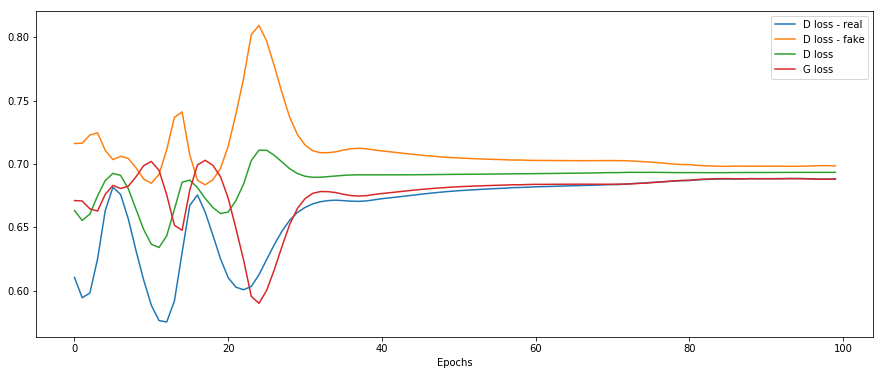

In [88]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(hist_d_loss_real)
plt.plot(hist_d_loss_fake)
plt.plot(hist_d_loss)
plt.plot(hist_g_loss)
ax.set_xlabel('Epochs')
ax.legend(['D loss - real', 
           'D loss - fake', 
           'D loss', 
           'G loss'])

In [89]:
# walk-forward validation
def GAN_walk_forward(model, X, y, size=1, debug=True):
    predictions = list()
    limit_range = len(X[:size])

    for t in range(0, limit_range):
        x_input = X[t]
        x_input = x_input.reshape(1, x_input.shape[0], x_input.shape[1])
        y_output = model.predict(x_input)
        predicted = y_output.reshape(1,)
        expected = y[t:t+1].reshape(1,)
        
        predictions.append(predicted)
        
        if debug == True:
            print('predicted={}, expected={}'.format(predicted, expected))
            
    return np.array(predictions)

In [90]:
size = 21 # (approx. one month) and 1 day prediction by default
predictions = GAN_walk_forward(gen_net, X_test, y_test, size=size)

predicted=[0.92815787], expected=[0.9225162]
predicted=[0.93092394], expected=[0.91918078]
predicted=[0.9240186], expected=[0.92296514]
predicted=[0.9246674], expected=[0.9142418]
predicted=[0.92276543], expected=[0.9235424]
predicted=[0.9233802], expected=[0.92918695]
predicted=[0.92286164], expected=[0.93220164]
predicted=[0.9299658], expected=[0.93354866]
predicted=[0.93406105], expected=[0.94656953]
predicted=[0.93816805], expected=[0.95471552]
predicted=[0.9444219], expected=[0.95805094]
predicted=[0.9542697], expected=[0.96138636]
predicted=[0.960055], expected=[0.96741574]
predicted=[0.96381897], expected=[0.96305402]
predicted=[0.96676433], expected=[0.96260508]
predicted=[0.9683539], expected=[0.97427891]
predicted=[0.9678814], expected=[0.97844821]
predicted=[0.97210723], expected=[0.98306646]
predicted=[0.9801504], expected=[0.96446516]
predicted=[0.98074436], expected=[0.9576661]
predicted=[0.9759819], expected=[0.95272713]


In [91]:
def revert_transformations(test, predictions):
    original_y_test = scaler.inverse_transform(test)
    original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

#     original_y_test = inv_boxcox(original_y_test, lmbda)
#     original_predictions = inv_boxcox(original_predictions, lmbda)
    
    return original_y_test, original_predictions

In [92]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)

In [93]:
from utils import rmse, plot_walk_forward_validation

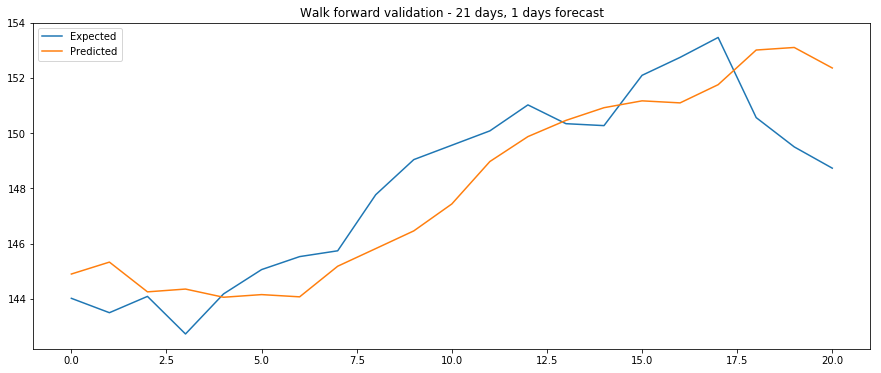

In [94]:
plot_walk_forward_validation(original_y_test, original_predictions, size)

In [95]:
print('GAN[%d days, %d day forecast] - RMSE: %.3f' % (size, 1, rmse(original_predictions, original_y_test[:size])))

GAN[21 days, 1 day forecast] - RMSE: 1.780


In [96]:
# walk-forward validation by looping over the steps
def GAN_walk_forward_by_looping(model, X, y, size=1, steps=1, debug=True):
    predictions = list()
    limit_range = len(X[:size])
    look_back = X[0].shape[0]
    n_features = X[0].shape[1]

    for t in range(0, limit_range, steps):
        x_input = X[t]
        x_input = x_input.reshape(1, look_back, n_features)
        
        step_predictions = []
        
        for p in range(steps):
            y_output = model.predict(x_input)
            
            # save the prediction in the sequence
            out_val = y_output.item(0)
            step_predictions.append(out_val)
            
            # get rid of the first price
            in_vals = x_input.flatten()[1:]
            
            # appends the new predicted one
            in_vals = np.append(in_vals, out_val)
            
            # reshape for the next prediction
            x_input = in_vals.reshape(1, look_back, n_features)
            
        predicted = np.array(step_predictions).reshape(steps,)
        expected = y[t:t+steps].reshape(steps,)
        
        predictions.append(predicted)
        
        if debug == True:
            print('predicted={}, expected={}'.format(predicted, expected))
            
    return np.array(predictions)

In [97]:
size = 21 # (approx. one month)
steps = 3 # 3 days prediction
predictions = GAN_walk_forward_by_looping(gen_net, X_test, y_test, size=size, steps=steps)

predicted=[0.92815787 0.93184537 0.92792755], expected=[0.9225162  0.91918078 0.92296514]
predicted=[0.92466742 0.92446929 0.92693341], expected=[0.9142418  0.9235424  0.92918695]
predicted=[0.92286164 0.92844069 0.93018359], expected=[0.93220164 0.93354866 0.94656953]
predicted=[0.93816805 0.94172496 0.9462356 ], expected=[0.95471552 0.95805094 0.96138636]
predicted=[0.96005499 0.96262217 0.96431029], expected=[0.96741574 0.96305402 0.96260508]
predicted=[0.96835393 0.96691871 0.96831763], expected=[0.97427891 0.97844821 0.98306646]
predicted=[0.9801504  0.98329002 0.98520738], expected=[0.96446516 0.9576661  0.95272713]


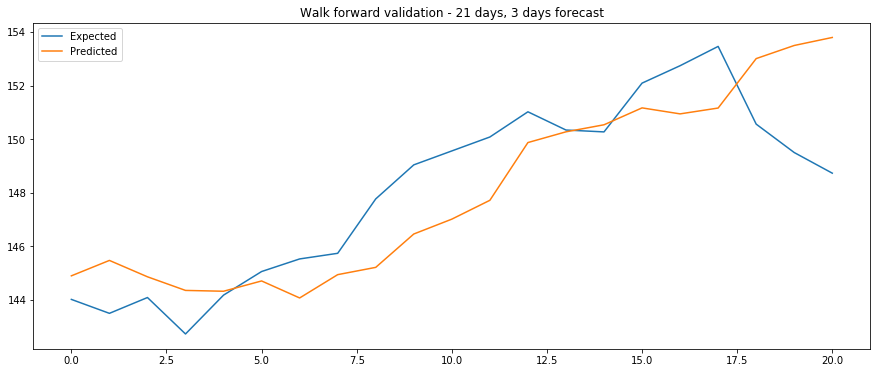

In [98]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [99]:
print('GAN[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

GAN[21 days, 3 day forecast] - RMSE: 2.120


In [100]:
size = 21 # approx. one month
steps = 7 # 7 days prediction
predictions = GAN_walk_forward_by_looping(gen_net, X_test, y_test, size=size, steps=steps)

predicted=[0.92815787 0.93184537 0.92792755 0.93250024 0.93385988 0.93356389
 0.93630117], expected=[0.9225162  0.91918078 0.92296514 0.9142418  0.9235424  0.92918695
 0.93220164]
predicted=[0.92996579 0.93347639 0.93486565 0.9350903  0.93737763 0.93853539
 0.93958366], expected=[0.93354866 0.94656953 0.95471552 0.95805094 0.96138636 0.96741574
 0.96305402]
predicted=[0.96676433 0.96902996 0.96837515 0.97089332 0.97224528 0.97294575
 0.97477955], expected=[0.96260508 0.97427891 0.97844821 0.98306646 0.96446516 0.9576661
 0.95272713]


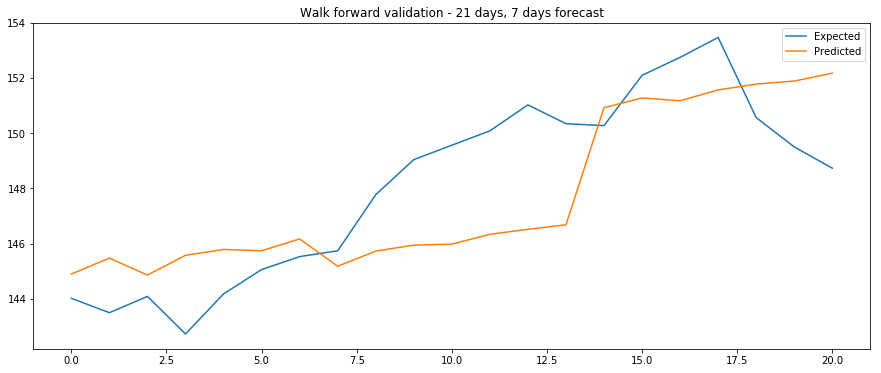

In [101]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [102]:
print('GAN[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

GAN[21 days, 7 day forecast] - RMSE: 2.365


In [103]:
size = 21 # approx. one month
steps = 21 # 21 days prediction
predictions = GAN_walk_forward_by_looping(gen_net, X_test, y_test, size=size, steps=steps)

predicted=[0.92815787 0.93184537 0.92792755 0.93250024 0.93385988 0.93356389
 0.93630117 0.93734771 0.93825799 0.94014865 0.94128901 0.94255573
 0.9441008  0.94534796 0.94670141 0.94811749 0.94942558 0.95079064
 0.95216161 0.95349652 0.95485628], expected=[0.9225162  0.91918078 0.92296514 0.9142418  0.9235424  0.92918695
 0.93220164 0.93354866 0.94656953 0.95471552 0.95805094 0.96138636
 0.96741574 0.96305402 0.96260508 0.97427891 0.97844821 0.98306646
 0.96446516 0.9576661  0.95272713]


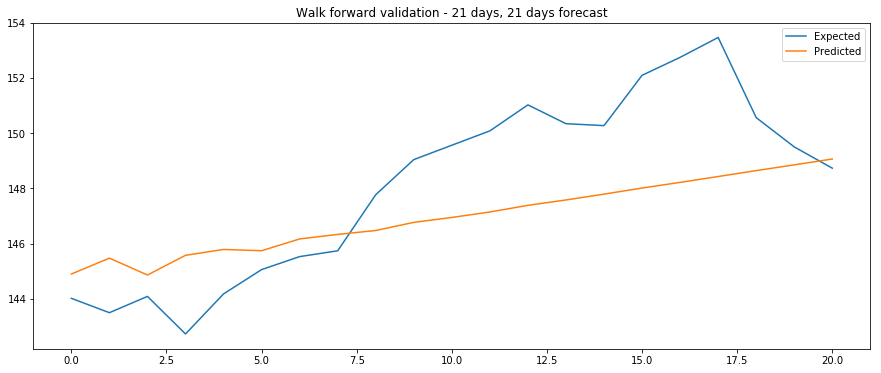

In [104]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [105]:
print('GAN[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

GAN[21 days, 21 day forecast] - RMSE: 2.517


In [106]:
size = 42 # approx. two months
steps = 42 # 42 days prediction
predictions = GAN_walk_forward_by_looping(gen_net, X_test, y_test, size=size, steps=steps)

predicted=[0.92815787 0.93184537 0.92792755 0.93250024 0.93385988 0.93356389
 0.93630117 0.93734771 0.93825799 0.94014865 0.94128901 0.94255573
 0.9441008  0.94534796 0.94670141 0.94811749 0.94942558 0.95079064
 0.95216161 0.95349652 0.95485628 0.95621127 0.9575547  0.95890713
 0.96025461 0.96159798 0.96294338 0.96428496 0.96562421 0.96696258
 0.9682979  0.9696309  0.97096163 0.97228962 0.97361493 0.97493744
 0.97625685 0.97757334 0.9788866  0.9801966  0.98150319 0.98280632], expected=[0.9225162  0.91918078 0.92296514 0.9142418  0.9235424  0.92918695
 0.93220164 0.93354866 0.94656953 0.95471552 0.95805094 0.96138636
 0.96741574 0.96305402 0.96260508 0.97427891 0.97844821 0.98306646
 0.96446516 0.9576661  0.95272713 0.96119394 1.00667074 0.99660047
 1.00186008 1.01738249 1.02552857 1.03181448 0.99499691 1.00885156
 1.02405333 1.03527822 1.03110891 1.011289   1.00897987 1.00711979
 1.02360429 1.02488711 1.02033307 1.02411744 1.03444433 1.04368083]


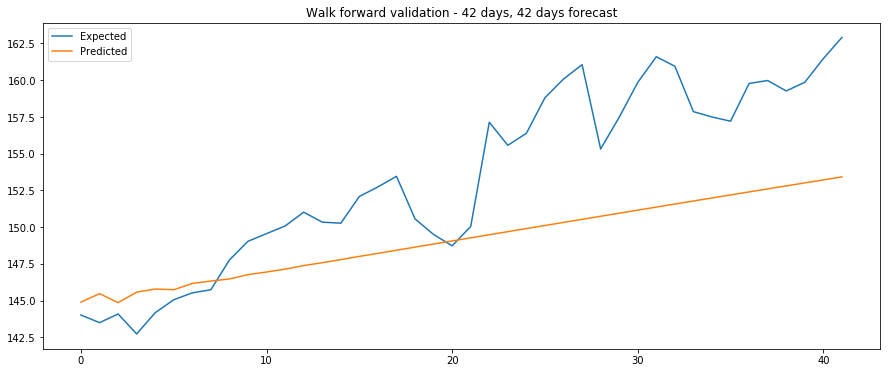

In [107]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [108]:
print('GAN[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

GAN[42 days, 42 day forecast] - RMSE: 5.629


In [109]:
size = 252 # approx. one year
steps = 252 # 252 days prediction
predictions = GAN_walk_forward_by_looping(gen_net, X_test, y_test, size=size, steps=steps)

predicted=[0.92815787 0.93184537 0.92792755 0.93250024 0.93385988 0.93356389
 0.93630117 0.93734771 0.93825799 0.94014865 0.94128901 0.94255573
 0.9441008  0.94534796 0.94670141 0.94811749 0.94942558 0.95079064
 0.95216161 0.95349652 0.95485628 0.95621127 0.9575547  0.95890713
 0.96025461 0.96159798 0.96294338 0.96428496 0.96562421 0.96696258
 0.9682979  0.9696309  0.97096163 0.97228962 0.97361493 0.97493744
 0.97625685 0.97757334 0.9788866  0.9801966  0.98150319 0.98280632
 0.98410583 0.98540157 0.98669332 0.98798132 0.98926502 0.99054468
 0.9918201  0.99309105 0.99435765 0.99561954 0.99687672 0.99812925
 0.99937683 1.00061929 1.0018568  1.00308907 1.00431633 1.00553787
 1.00675416 1.00796497 1.00917006 1.01036954 1.0115633  1.01275098
 1.01393294 1.01510882 1.01627851 1.01744223 1.01859951 1.0197506
 1.02089548 1.02203345 1.02316535 1.02429056 1.02540898 1.02652097
 1.02762604 1.02872419 1.02981591 1.03090024 1.03197777 1.03304851
 1.03411198 1.03516841 1.03621781 1.03725982 1.038294

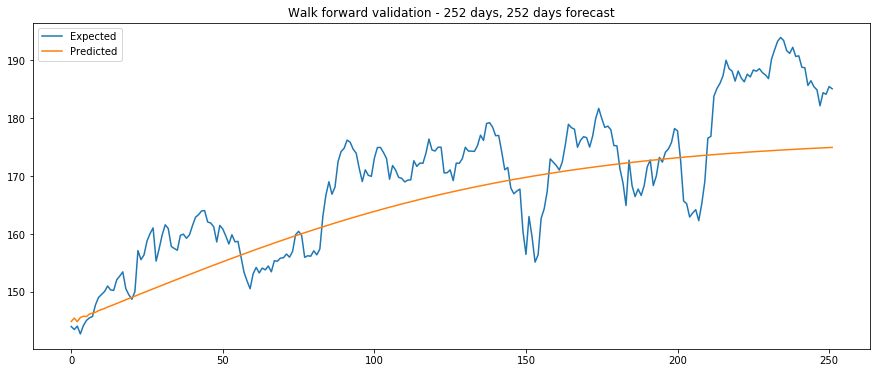

In [110]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [111]:
print('GAN[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

GAN[252 days, 252 day forecast] - RMSE: 8.030
